In [ ]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praveenstephen03","key":"408554b28f1102eadca6aecc98fefaed"}'}

In [3]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 96% 314M/329M [00:03<00:00, 103MB/s]
100% 329M/329M [00:03<00:00, 108MB/s]


In [7]:
!unzip plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

In [8]:
!pip install tensorflow

In [9]:
!pip install pandas
!pip install matplotlib
!pip install numpy

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers


In [4]:
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE=192
BATCH_SIZE= 8
CHANNELS=3
EPOCHS=10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names=dataset.class_names
class_names


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
len(dataset)

2580

In [9]:
train_size=0.8
len(dataset)*train_size

2064.0

In [10]:
test_ds=dataset.skip(2064)
len(test_ds)

516

In [11]:
val_size=0.1
len(dataset)*val_size

258.0

In [12]:
val_ds=test_ds.take(258)
len(val_ds)

258

In [13]:
test_ds=test_ds.skip(258)
len(test_ds)

258

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=250):
    ds_size= len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

2064

In [36]:
len(val_ds)

258

In [37]:
len(val_ds)

258

In [38]:
#don't run for normal; run for batch
#train_ds=train_ds.cache().shuffle(250).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds=val_ds.cache().shuffle(250).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds=test_ds.cache().shuffle(250).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [40]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [41]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

IMAGE_SIZE = 192
CHANNELS = 3
NUM_CLASSES = 15

base_model = applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights='imagenet'
)

In [43]:
base_model.trainable = False

In [44]:
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),

    # Rescale pixel values
    layers.Rescaling(1./255),

    # MobileNetV2 Feature Extractor
    base_model,

    # Global Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
   layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 192, 192, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_192 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,431,183 (9.27 MB)

 Trainable params: 173,199 (676.56 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [47]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 147s 65ms/step - accuracy: 0.3762 - loss: 1.9304 - val_accuracy: 0.7529 - val_loss: 0.8348 - learning_rate: 0.0010
Epoch 2/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 128s 61ms/step - accuracy: 0.6154 - loss: 1.1599 - val_accuracy: 0.7897 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 3/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - accuracy: 0.6596 - loss: 1.0280 - val_accuracy: 0.8120 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 4/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 130s 62ms/step - accuracy: 0.6779 - loss: 0.9741 - val_accuracy: 0.8285 - val_loss: 0.5843 - learning_rate: 0.0010
Epoch 5/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.6928 - loss: 0.9217 - val_accuracy: 0.8469 - val_loss: 0.5723 - learning_rate: 0.0010
Epoch 6/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step - accuracy: 0.6958 - loss: 0.9028 - val_accuracy: 0.8183 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 7/10
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 124s 59ms/step -

In [48]:
scores=model.evaluate(test_ds)

258/258 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8455 - loss: 0.5160


In [49]:
scores

[0.5468387007713318, 0.84238600730896]

first image to predict
actual label: Tomato_Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Tomato_Leaf_Mold


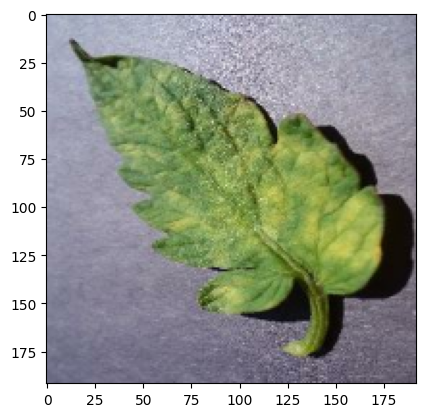

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [51]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


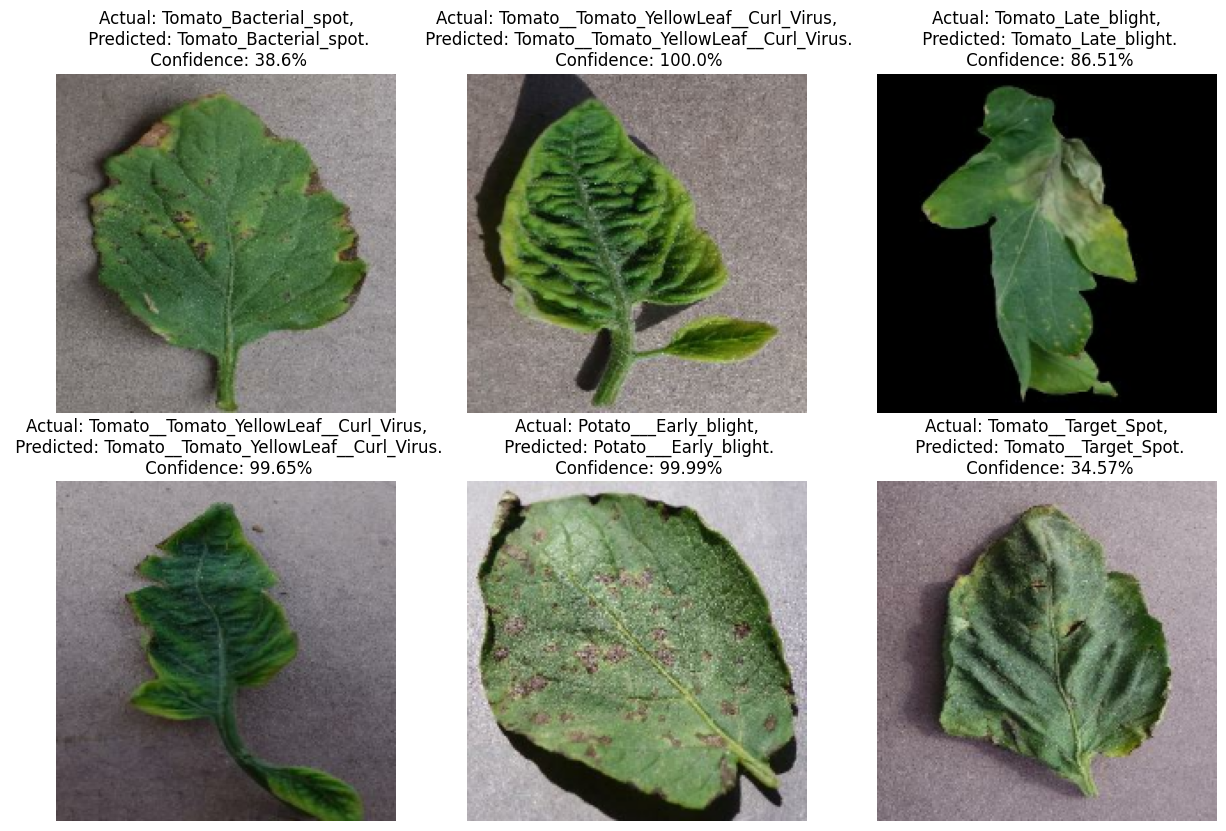

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [54]:
import os

# Create 'models' folder if not exists
os.makedirs('/content/models', exist_ok=True)


In [55]:
model.save('/content/models/mobilenetv2_model.h5')  # HDF5 format

In [ ]:

from tensorflow.keras.preprocessing import image